<a href="https://colab.research.google.com/github/Hansanghyun-github/our_prototype/blob/main/prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# simple transformer

In [ ]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 198 kB/s 


In [ ]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim 
import torch.backends.cudnn as cudnn 
import torchvision 
import torchvision.transforms as transforms

import os
import pandas as pd
import csv
import numpy as np
from einops import rearrange 

import matplotlib.pyplot as plt
import pdb

In [ ]:
import albumentations

In [ ]:
# transformer encoder의 residual connection
class Residual(nn.Module):
  def __init__(self, fn): 
    super().__init__()
    self.fn = fn 

  def forward(self, x):
    return self.fn(x) + x

In [ ]:
# transformer encoder의 layer normalization
class PreNorm(nn.Module): 
  def __init__(self, dim, fn):
    super().__init__()
    self.norm = nn.LayerNorm(dim)
    self.fn = fn 

  def forward(self, x):
    return self.fn(self.norm(x))

In [ ]:
# transformer encoder의 MLP layer
class FeedForward(nn.Module):
  def __init__(self, dim, hidden_dim, dropout=0.):
    super().__init__() 
    self.net = nn.Sequential(
        nn.Linear(dim, hidden_dim), 
        nn.GELU(), 
        nn.Dropout(dropout),
        nn.Linear(hidden_dim, dim), 
        nn.Dropout(dropout)
    )

  def forward(self, x): 
    return self.net(x)

# Multi-Head Self-Attention layer
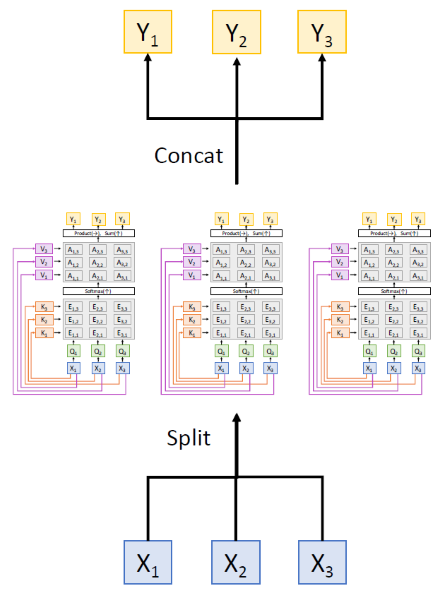

In [ ]:
# transformer encoder의 Multi-Head Self-Attention
class Attention(nn.Module): 
  def __init__(self, dim, heads=8, dropout=0.):
    super().__init__()
    self.heads = heads 
    self.scales = heads ** (-0.5)

    self.to_qkv = nn.Linear(dim, dim * 3, bias=False)
    self.to_out = nn.Sequential(
        nn.Linear(dim, dim), 
        nn.Dropout(dropout)
    )

  def forward(self, x):
    b, n, _, h = *x.shape, self.heads

    # input vector를 이용해서 query, key, value vector 생성
    # (batch, n, dim)이 3개인 tuple 형태
    qkv = self.to_qkv(x).chunk(3, dim=-1)

    # 각각의 vector를 head 만큼 split
    # (batch, n, dim) -> (batch, head, n, dim/head)
    q, k, v = map(lambda t: rearrange(t, "b n (h d) -> b h n d", h=h), qkv)

    # compute similarity (scaled dot product) (batch와 head를 유지하면서 행렬곱 진행)
    # (batch, head, i, d), (batch, head, j, d) -> (batch, head, i, j) // (i는 query의 개수, j는 key의 개수)
    dots = torch.einsum("bhid, bhjd->bhij", q, k) * self.scales

    # compute attention weights
    # (batch, head, i, j)
    attn = dots.softmax(dim=-1)

    # compute output vector (batch와 head 유지하면서 행렬곱 진행)
    # (batch, head, i, j), (batch, head, i, d) -> (batch, head, i, d)
    out = torch.einsum("bhij,bhjd->bhid", attn, v)

    # split했던 head들을 concat
    # (batch, head, i, d) -> (batch, i, head * d)
    out = rearrange(out, "b h n d -> b n (h d)")

    out = self.to_out(out)
    return out

In [ ]:
# transformer encoder
class Transformer(nn.Module):
  def __init__(self, dim, depth, heads, mlp_dim, dropout):
    super().__init__()
    self.layers = nn.ModuleList([])

    # depth만큼 transformer block 쌓음
    for _ in range(depth):
      self.layers.append(nn.ModuleList([
                                        Residual(PreNorm(dim, Attention(dim, heads=heads, dropout=dropout))), 
                                        Residual(PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout)))
      ]))

  def forward(self, x):
    for attn, ff in self.layers:
      x = attn(x) # LayerNorm->Attention->Residual connection
      x = ff(x)   # LayerNorm->MLP Layer->Residual connection
    return x

In [ ]:
n = 11
x = torch.rand([4,n,3])
print(x.shape)
x1,y = x.chunk(2,  dim = 1)
print(x1.shape)
print(y.shape)
z = torch.cat([x1, y], dim=1)
print(z.shape)

print(z == x)

#csp_transformer

In [ ]:
# transformer encoder
class CSP_Transformer(nn.Module):
  def __init__(self, dim, depth, heads, mlp_dim, dropout):
    super().__init__()
    self.layers = nn.ModuleList([])
    
    self.CSPS1 = Residual(PreNorm(dim, Attention(dim, heads=heads, dropout=dropout)))
    self.CSPS2 = Residual(PreNorm(dim, Attention(dim, heads=heads, dropout=dropout)))
    self.FFN1 = Residual(PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout)))
    self.FFN2 = Residual(PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout)))

    # depth만큼 transformer block 쌓음
    for _ in range(depth - 2):
      self.layers.append(nn.ModuleList([
                                        Residual(PreNorm(dim, Attention(dim, heads=heads, dropout=dropout))), 
                                        Residual(PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout)))
      ]))

  def forward(self, x):
    x1, x2 = x.chunk(2, dim = 1)
    x2 = self.CSPS1(x2)
    x = torch.cat([x1, x2], dim=1)
    x = self.FFN1(x)

    x1, x2 = x.chunk(2, dim = 1)
    x1 = self.CSPS2(x1)
    x = torch.cat([x1, x2], dim=1)
    x = self.FFN2(x)

    for attn, ff in self.layers:
      x = attn(x) # LayerNorm->Attention->Residual connection
      x = ff(x)   # LayerNorm->MLP Layer->Residual connection
    return x

# vit layer

In [ ]:
MIN_NUM_PATCHES = 16
class ViT(nn.Module): 
  def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels=3, dropout=0., emb_dropout=0.):
    super().__init__()
    assert image_size % patch_size == 0, "image size must be divisible for the patch size"
    num_patches = (image_size // patch_size) ** 2
    patch_dim = channels * patch_size**2 
    assert num_patches >= MIN_NUM_PATCHES,  f'your number of patches ({num_patches}) is way too small for attention to be effective. try decreasing your patch size'

    self.patch_size = patch_size 

    self.pos_embedding = nn.Parameter(torch.randn(1, num_patches+1, dim))
    self.patch_to_embedding = nn.Linear(patch_dim, dim, bias=False)
    self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
    self.dropout = nn.Dropout(emb_dropout)

    self.transformer = Transformer(dim, depth, heads, mlp_dim, dropout)

    self.to_cls_token = nn.Identity()

    self.mlp_head = nn.Sequential(
        nn.LayerNorm(dim), 
        nn.Linear(dim, mlp_dim), 
        nn.GELU(), 
        nn.Dropout(dropout), 
        nn.Linear(mlp_dim, num_classes)
    )

  def forward(self, img):
    # img shape = (batch size, channel, height, width)

    p = self.patch_size
    
    # 이미지를 패치로 자름, 각 패치를 flatten(1-Dimension) 하게 만듬
    # (batch size, channel, height, width) -> (batch size, number of patch, patch_dim)
    x = rearrange(img, "b c (h p1) (w p2) -> b (h w) (p1 p2 c)", p1=p, p2=p)
    
    # patch embedding
    # (batch size, number of patch, patch_dim) -> (batch size, number of patch, dim)
    x = self.patch_to_embedding(x)
    b, n, _ = x.shape

    # class token embedding vector를 batch size만큼 확장
    # (batch size, 1, dim)
    cls_tokens = self.cls_token.expand(b, -1, -1)

    # x 맨 앞에 cls_tokens 붙힘
    # (batch size, number of patch, dim) -> (batch size, number of patch + 1, dim)
    x = torch.cat((cls_tokens, x), dim=1)

    # x에 pos_embedding 더해줌
    # shape 같음
    x += self.pos_embedding[:, :(n+1)]
    x = self.dropout(x)

    # trnasformer encoder layer
    # (batch size, number of patch + 1, dim) -> (batch size, number of patch + 1, dim)
    x = self.transformer(x)

    # x 맨앞의 head(class token embedding vector) 추출
    # (batch size, number of patch + 1, dim) -> (batch size, dim)
    x = self.to_cls_token(x[:, 0])

    # mlp layer를 통해 output 구함
    # (batch size, dim) -> (batch size, class size(10))
    return self.mlp_head(x)

#csp vit

In [ ]:
MIN_NUM_PATCHES = 16
class CSP_ViT(nn.Module): 
  def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels=3, dropout=0., emb_dropout=0.):
    super().__init__()
    assert image_size % patch_size == 0, "image size must be divisible for the patch size"
    num_patches = (image_size // patch_size) ** 2
    patch_dim = channels * patch_size**2 
    assert num_patches >= MIN_NUM_PATCHES,  f'your number of patches ({num_patches}) is way too small for attention to be effective. try decreasing your patch size'

    self.patch_size = patch_size 

    self.pos_embedding = nn.Parameter(torch.randn(1, num_patches+1, dim))
    self.patch_to_embedding = nn.Linear(patch_dim, dim, bias=False)
    self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
    self.dropout = nn.Dropout(emb_dropout)

    self.transformer = CSP_Transformer(dim, depth, heads, mlp_dim, dropout)

    self.to_cls_token = nn.Identity()

    self.mlp_head = nn.Sequential(
        nn.LayerNorm(dim), 
        nn.Linear(dim, mlp_dim), 
        nn.GELU(), 
        nn.Dropout(dropout), 
        nn.Linear(mlp_dim, num_classes)
    )

  def forward(self, img):
    # img shape = (batch size, channel, height, width)

    p = self.patch_size
    
    # 이미지를 패치로 자름, 각 패치를 flatten(1-Dimension) 하게 만듬
    # (batch size, channel, height, width) -> (batch size, number of patch, patch_dim)
    x = rearrange(img, "b c (h p1) (w p2) -> b (h w) (p1 p2 c)", p1=p, p2=p)
    
    # patch embedding
    # (batch size, number of patch, patch_dim) -> (batch size, number of patch, dim)
    x = self.patch_to_embedding(x)
    b, n, _ = x.shape

    # class token embedding vector를 batch size만큼 확장
    # (batch size, 1, dim)
    cls_tokens = self.cls_token.expand(b, -1, -1)

    # x 맨 앞에 cls_tokens 붙힘
    # (batch size, number of patch, dim) -> (batch size, number of patch + 1, dim)
    x = torch.cat((cls_tokens, x), dim=1)

    # x에 pos_embedding 더해줌
    # shape 같음
    x += self.pos_embedding[:, :(n+1)]
    x = self.dropout(x)

    # trnasformer encoder layer
    # (batch size, number of patch + 1, dim) -> (batch size, number of patch + 1, dim)
    x = self.transformer(x)

    # x 맨앞의 head(class token embedding vector) 추출
    # (batch size, number of patch + 1, dim) -> (batch size, dim)
    x = self.to_cls_token(x[:, 0])

    # mlp layer를 통해 output 구함
    # (batch size, dim) -> (batch size, class size(10))
    return self.mlp_head(x)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0
start_epoch = 0 

In [ ]:
net = ViT(
    image_size = 32,
    patch_size = 4,
    num_classes = 10,
    dim = 512,
    depth = 6,
    heads = 8,
    mlp_dim = 512,
    dropout = 0.1,
    emb_dropout = 0.1
)
net = net.to(device)

# 하이퍼파라미터, CIFAR10 dataset


In [ ]:
# hyperparameter

lr = 1e-4 
bs = 128
n_epochs = 50
patch = 2


In [ ]:
transform_train = transforms.Compose([
                                     # 이미지를 첫번째 인자의 사이즈로 자름, padding 크기만큼 의미없는 pixel(값 0) 채움
                                     transforms.RandomCrop(32, padding=4),
                                      
                                     # 이미지를 수평으로 뒤집는다
                                     transforms.RandomHorizontalFlip(),
                                      
                                     # 데이터를 tensor로 변환
                                     transforms.ToTensor(),
                                      
                                     # (mean, std) 괄호안의 수의 개수는 채널의 수
                                     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [ ]:
# CIFAR-10 dataset dataloader

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# optimizer, scheduler

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True, min_lr=1e-3*1e-5, factor=0.1)

# train, test 함수

In [ ]:
def train(epoch):
  print('\nEpoch: %d' % epoch)
  net.train()
  train_loss = 0
  correct = 0
  total = 0

  for batch_idx, (inputs, targets) in enumerate(trainloader):
    
    inputs, targets = inputs.to(device), targets.to(device)
    optimizer.zero_grad()
    outputs = net(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    _, predicted = outputs.max(1)
    total += targets.size(0)
    correct += predicted.eq(targets).sum().item()

  return train_loss/(batch_idx+1)

In [ ]:
import time
def test(epoch):
  global best_acc
  net.eval() 
  test_loss = 0 
  correct = 0 
  total = 0 

  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(trainloader): 
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = net(inputs)
      loss = criterion(outputs, targets)
      test_loss += loss.item() 
      _, predicted = outputs.max(1)
      total += targets.size(0) 
      correct += predicted.eq(targets).sum().item()
      

  scheduler.step(test_loss)
  acc = 100. * correct/total

  if acc > best_acc: 
    print("Best accuracy: {}".format(acc))
  return test_loss, acc

# 학습진행

In [ ]:

n_epochs = 10
list_loss = []
list_acc = []
for epoch in range(n_epochs):
  train(epoch)
  val_loss, val_acc = test(epoch)

  list_loss.append(val_loss)
  list_acc.append(val_acc)



Epoch: 0
Best accuracy: 52.608

Epoch: 1
Best accuracy: 55.506

Epoch: 2
Best accuracy: 57.658

Epoch: 3
Epoch 00006: reducing learning rate of group 0 to 1.0000e-05.
Best accuracy: 58.814

Epoch: 4
Best accuracy: 61.33

Epoch: 5
Best accuracy: 62.298

Epoch: 6
Best accuracy: 62.71

Epoch: 7
Epoch 00010: reducing learning rate of group 0 to 1.0000e-06.
Best accuracy: 63.024

Epoch: 8
Best accuracy: 62.674

Epoch: 9
Best accuracy: 63.284


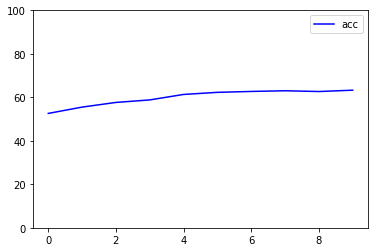

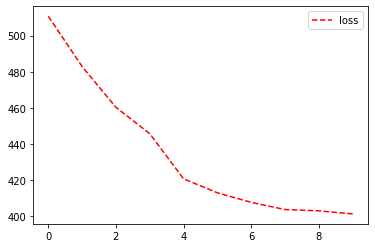

In [ ]:
%matplotlib inline 
plt.plot(list_acc, label = "acc", color = 'blue')
plt.ylim(0,100)
plt.legend(loc = 0)
plt.show()
plt.plot(list_loss, label = "loss", color = 'red', linestyle = "--")
plt.legend(loc = 0)
plt.show()

In [ ]:
!pip install torchsummary

In [ ]:
from torchsummary import summary

summary(net, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 64, 512]          24,576
           Dropout-2              [-1, 65, 512]               0
         LayerNorm-3              [-1, 65, 512]           1,024
            Linear-4             [-1, 65, 1536]         786,432
            Linear-5              [-1, 65, 512]         262,656
           Dropout-6              [-1, 65, 512]               0
         Attention-7              [-1, 65, 512]               0
           PreNorm-8              [-1, 65, 512]               0
          Residual-9              [-1, 65, 512]               0
        LayerNorm-10              [-1, 65, 512]           1,024
           Linear-11              [-1, 65, 512]         262,656
             GELU-12              [-1, 65, 512]               0
          Dropout-13              [-1, 65, 512]               0
           Linear-14              [-1, 

# 학습된 모델 드라이브에 저장, 업로드

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls /content/gdrive/MyDrive

'Colab Notebooks'       seq2seq_attention.ipynb   Untitled0.ipynb
 자연어처리실습.ipynb  'seq2seq with attention'   Untitled1.ipynb
 notebook	        simple_VIT.pt		  vit_tutorial.ipynb


In [ ]:
model_save_name = 'simple_VIT.pt'
path = F"/content/gdrive/MyDrive/{model_save_name}" 
torch.save(net.state_dict(), path)

In [ ]:
net.load_state_dict(torch.load(path))

<All keys matched successfully>

# test data의 label과 output 비교


In [ ]:
def my_test(x):
  net.eval() 

  with torch.no_grad():
    outputs = net(x)
    _, predicted = outputs.max(1)

  return predicted

label: plane
predicted: plane



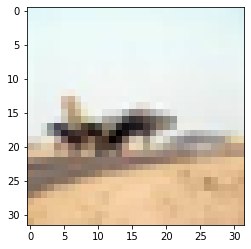

In [ ]:
import random
######### 0 ~ 9999 ###############
#num = 10
num = random.randint(0,9999)
##################################

compare_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=False)
img, _ = compare_set[num]

x, label = testset[num]
x = x.unsqueeze(dim=0).to(device)

predicted = my_test(x)

print('label:', classes[label])
print('predicted:', classes[predicted])
plt.imshow(img)
print()

#csp train and test

In [ ]:
csp_net = CSP_ViT(
    image_size = 32,
    patch_size = 4,
    num_classes = 10,
    dim = 512,
    depth = 6,
    heads = 8,
    mlp_dim = 512,
    dropout = 0.1,
    emb_dropout = 0.1
)
csp_net = csp_net.to(device)

In [ ]:
from torchsummary import summary

summary(csp_net, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 64, 512]          24,576
           Dropout-2              [-1, 65, 512]               0
         LayerNorm-3              [-1, 32, 512]           1,024
            Linear-4             [-1, 32, 1536]         786,432
            Linear-5              [-1, 32, 512]         262,656
           Dropout-6              [-1, 32, 512]               0
         Attention-7              [-1, 32, 512]               0
           PreNorm-8              [-1, 32, 512]               0
          Residual-9              [-1, 32, 512]               0
        LayerNorm-10              [-1, 65, 512]           1,024
           Linear-11              [-1, 65, 512]         262,656
             GELU-12              [-1, 65, 512]               0
          Dropout-13              [-1, 65, 512]               0
           Linear-14              [-1, 

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(csp_net.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True, min_lr=1e-3*1e-5, factor=0.1)

In [ ]:
def csp_train(epoch):
  print('\nEpoch: %d' % epoch)
  csp_net.train()
  train_loss = 0
  correct = 0
  total = 0

  for batch_idx, (inputs, targets) in enumerate(trainloader):
    
    inputs, targets = inputs.to(device), targets.to(device)
    optimizer.zero_grad()
    outputs = csp_net(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    _, predicted = outputs.max(1)
    total += targets.size(0)
    correct += predicted.eq(targets).sum().item()

  return train_loss/(batch_idx+1)

In [ ]:
import time
def csp_test(epoch):
  global best_acc
  csp_net.eval() 
  test_loss = 0 
  correct = 0 
  total = 0 

  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(trainloader): 
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = csp_net(inputs)
      loss = criterion(outputs, targets)
      test_loss += loss.item() 
      _, predicted = outputs.max(1)
      total += targets.size(0) 
      correct += predicted.eq(targets).sum().item()
      

  scheduler.step(test_loss)
  acc = 100. * correct/total

  if acc > best_acc: 
    print("Best accuracy: {}".format(acc))
  return test_loss, acc

In [ ]:

n_epochs = 10
list_loss_csp = []
list_acc_csp = []
for epoch in range(n_epochs):
  csp_train(epoch)
  val_loss, val_acc = csp_test(epoch)

  list_loss_csp.append(val_loss)
  list_acc_csp.append(val_acc)



Epoch: 0
Best accuracy: 44.652

Epoch: 1
Best accuracy: 49.326

Epoch: 2
Best accuracy: 51.864

Epoch: 3
Epoch 00005: reducing learning rate of group 0 to 1.0000e-05.
Best accuracy: 54.728

Epoch: 4
Best accuracy: 57.354

Epoch: 5
Best accuracy: 57.972

Epoch: 6
Best accuracy: 58.364

Epoch: 7
Epoch 00009: reducing learning rate of group 0 to 1.0000e-06.
Best accuracy: 58.824

Epoch: 8
Best accuracy: 58.984

Epoch: 9
Best accuracy: 59.238


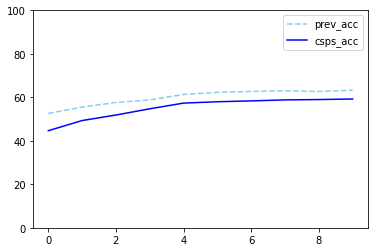

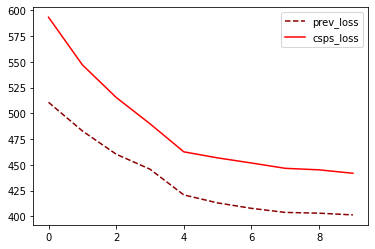

In [ ]:
%matplotlib inline 
plt.plot(list_acc, label = "prev_acc", color = 'skyblue', linestyle = "--")
plt.plot(list_acc_csp, label = "csps_acc", color = 'blue')
plt.ylim(0,100)
plt.legend(loc = 0)
plt.show()
plt.plot(list_loss, label = "prev_loss", color = 'darkred', linestyle = "--")
plt.plot(list_loss_csp, label = "csps_loss", color = 'red')
plt.legend(loc = 0)
plt.show()

In [ ]:
import time
start = time.time()
end = time.time()

print(f"{end - start:.5f} sec")

0.00002 sec


In [ ]:
def prev_test(epoch):
  tmp = 0.0
  global best_acc
  net.eval() 
  test_loss = 0 
  correct = 0 
  total = 0 

  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(testloader): 
      inputs, targets = inputs.to(device), targets.to(device)
      start = time.time()
      outputs = net(inputs)
      end = time.time()
      tmp += end - start
      loss = criterion(outputs, targets)
      test_loss += loss.item() 
      _, predicted = outputs.max(1)
      total += targets.size(0) 
      correct += predicted.eq(targets).sum().item()
      

  scheduler.step(test_loss)
  acc = 100. * correct/total

  if acc > best_acc: 
    print("Best accuracy: {}".format(acc))
  return tmp/10000, test_loss, acc

In [ ]:
start = time.time()
prev_test(0)
end = time.time()
print(f"{end - start:.6f} sec")

Best accuracy: 63.17
5.518388 sec


In [ ]:
sum = 0.0
for _ in range(10):
  tmp, _, _ = prev_test(0)
  sum += tmp
sum /= 10
print(f"{sum:.6f} sec")

Best accuracy: 63.17
Best accuracy: 63.17
Best accuracy: 63.17
Best accuracy: 63.17
Best accuracy: 63.17
Best accuracy: 63.17
Best accuracy: 63.17
Best accuracy: 63.17
Best accuracy: 63.17
Best accuracy: 63.17
0.00022 sec


In [ ]:
import time
def csps_test(epoch):
  tmp = 0.0
  global best_acc
  csp_net.eval() 
  test_loss = 0 
  correct = 0 
  total = 0 

  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(testloader): 
      inputs, targets = inputs.to(device), targets.to(device)
      start = time.time()
      outputs = csp_net(inputs)
      end = time.time()
      tmp += end - start
      loss = criterion(outputs, targets)
      test_loss += loss.item() 
      _, predicted = outputs.max(1)
      total += targets.size(0) 
      correct += predicted.eq(targets).sum().item()
      

  scheduler.step(test_loss)
  acc = 100. * correct/total

  if acc > best_acc: 
    print("Best accuracy: {}".format(acc))
  return tmp/10000, test_loss, acc

In [ ]:
start = time.time()
csps_test(0)
end = time.time()
print(f"{end - start:.6f} sec")

Best accuracy: 60.48
4.855452 sec


In [ ]:
sum = 0.0
for _ in range(10):
  tmp, _, _ = csps_test(0)
  sum += tmp
sum /= 10
print(f"{sum:.6f} sec")

Best accuracy: 60.48
Best accuracy: 60.48
Best accuracy: 60.48
Best accuracy: 60.48
Best accuracy: 60.48
Best accuracy: 60.48
Best accuracy: 60.48
Best accuracy: 60.48
Best accuracy: 60.48
Best accuracy: 60.48
0.00010 sec


In [ ]:
len(testset)

10000